## Phising Dataset

To collect the dataset, we have deployed multiple agents and soluble agents within an infrastructure with
more than 3k entities, comprising laptops, workstations, and smartphone devices. <br> The methods to build
ground truth are as follows:

- Simulator: We launch different realistic phishing campaigns, aiming to expose user credentials or defeat access to a service.
- IDS: We deploy an IDS to collect various alerts associated with behavioral anomalies, such as cryptomining or peer-to-peer traffic.

For each user exposed to the behaviors stated in the summary table, different TW is computed, aggregating
user behavior within a fixed time interval. <br> This TW serves as the basis for generating various supervised
and unsupervised methods.

## Time window representation 

The time windows (TW) are a data representation based on aggregated logs from multimodal sources between two
timestamps. <br> In this study, logs from HTTP, DNS, SSL, and SMTP are taken into consideration, allowing the
construction of rich behavioral profiles. <br> The indicators described in the TE are a set of manually curated
interpretable features designed to describe device-level properties within the specified time frame.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from modules.lib_IF import *
from modules.lib import *
from modules.optimizer import *
from xai_client import Client
import json
import io

In [2]:
entity = "desktop" #desktop or smartphone
threat = "phishing_behaviour" 
path_dataset = f'data/Risky Behaviour Datasets/{threat}/min_windows_size_6/{entity}_features.pckl'
seed = 42
dataset = pd.read_pickle(path_dataset)

In [3]:
dataset.head()

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,entity,label,user_id,timestamp
0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 05:00:00
0,13.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.166667,0.166667,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 05:10:00
0,29.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.500000,0.166667,0.166667,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 05:20:00
0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.000000,0.000000,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 06:00:00
0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.000000,0.000000,0,-1,5c9f3e1a089abe89c69185dac47f4e6c2664b8b2d33492...,2022-10-14 06:10:00


#### Load and split dataset based on the unique users

In [4]:
from sklearn.model_selection import train_test_split


unique_users = dataset.loc[dataset["label"] != -1, 'user_id'].unique()
# Split user IDs into train_test and validation sets
# We fix validation dataset to be always the same by fixing the random state, the rest changes
users_train_test, users_validation = train_test_split(unique_users, test_size=0.3, random_state=seed)

data_train_test = dataset[dataset['user_id'].isin(users_train_test)]
data_validation_labeled = dataset[dataset['user_id'].isin(users_validation)]


In [5]:
data_train_test = data_train_test.drop(columns=["timestamp", "user_id", "entity"])

In [6]:
data_validation_labeled = data_validation_labeled.drop(columns=["timestamp", "user_id", "entity"])

### Model creation and Training

In [7]:
import numpy as np
cat_columns = data_train_test.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = data_train_test.drop(columns='label').select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])

hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])

optimizer = ModelOptimizer(ml_pipeline,param_grid=hyperparameters,optimization_algorithm='grid_search')
opt = optimizer.optimize(data_train_test.drop(columns='label'),data_train_test.label)

In [8]:
hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [9]:
import joblib

opt = joblib.load('proxy_data_models/phising_fullgrid.pkl')

In [10]:
# import joblib


# joblib.dump(opt, 'phising_fullgrid.pkl')

Accuracy Score is 0.647415329768271


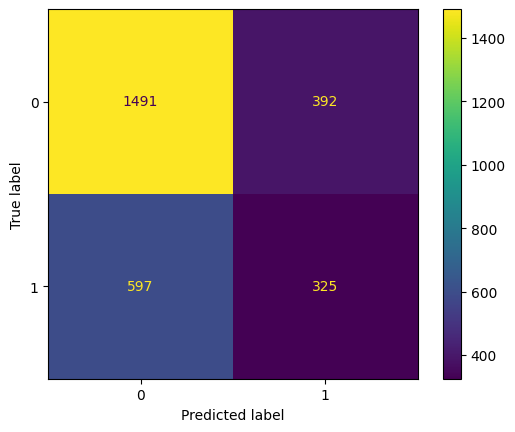

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test = data_validation_labeled.drop(columns='label')
test_labels = data_validation_labeled.label
best_model = opt.best_estimator_
pred_y_test = best_model.predict(test)

print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [12]:
cm = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

In [13]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1883
           1       0.45      0.35      0.40       922

    accuracy                           0.65      2805
   macro avg       0.58      0.57      0.57      2805
weighted avg       0.63      0.65      0.63      2805



In [14]:
classification_report = pd.DataFrame(classification_report(test_labels, pred_y_test,output_dict=True)).transpose()

## Proxy Model creation for PDP-ALE and Counterfactual Explanations

In [15]:
# proxy model for PDP-ALE
surrogate_model_accuracy = proxy_model(opt.param_grid,opt,'accuracy','XGBoostRegressor')

In [16]:
missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
missclassified['Predicted'] = pred_y_test
missclassified['Label'] = (missclassified['GroundTruth'] != missclassified['Predicted']).astype(int)
missclassified[missclassified['Label']==1]

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,GroundTruth,Predicted,Label
2,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,1,1
4,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,1,1
5,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
9,21.0,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
10,0.0,0.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2801,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2802,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2803,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1


In [17]:
misclassified_instance = missclassified.drop(columns=['GroundTruth','Label','Predicted']).loc[5]
train = data_train_test.drop(columns='label')
train_labels = data_train_test.label
#proxy_model and dataset for counterfactual explanations
#proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, misclassified_instance,hyperparameters)

In [18]:
proxy_model = joblib.load('proxy_data_models/phising_cfproxy.pkl')

In [19]:
# joblib.dump(proxy_model, 'phising_cfproxy.pkl')

In [20]:
proxy_dataset = pd.read_csv('proxy_data_models/phising_cfdataset.csv')

## Create gRPC Client

### Run `python xai_server.py` command on terminal in order to start server

### Compute PDP 1D Plots via gRPC

In [21]:
hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [22]:
client = Client()
xi,yi = client.get_explanations(explanation_type='Pipeline',explanation_method='PDPlots',model=surrogate_model_accuracy,param_grid=transform_grid_plt(hyperparameters))
xi = json.loads(xi)
yi = json.loads(yi)

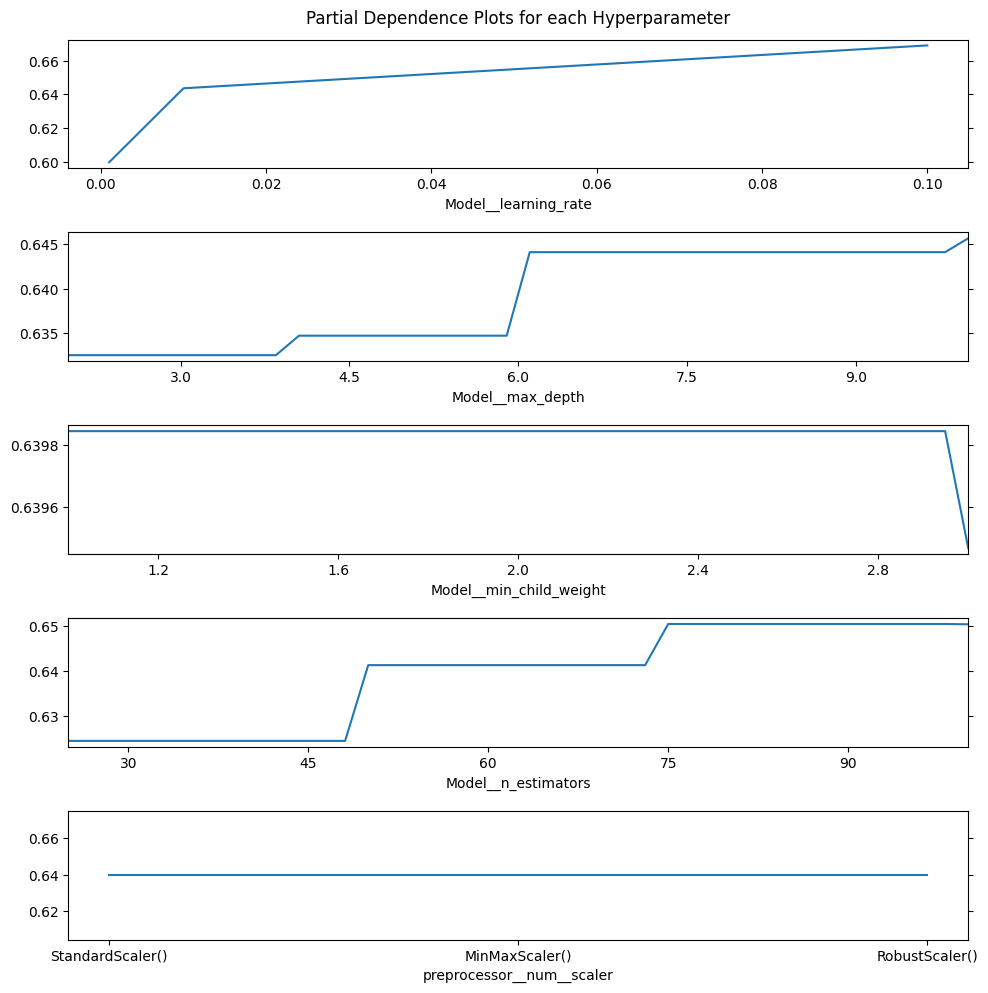

In [23]:
plot_pdp_1D_grpc(xi,yi,transform_grid_plt(hyperparameters))

### Compute PDP 2D Plots via gRPC

In [24]:
xi , yi , zi= client.get_explanations(explanation_type='Pipeline',explanation_method='2D_PDPlots',param_grid=transform_grid_plt(hyperparameters),model=surrogate_model_accuracy,feature1='Model__max_depth',feature2='Model__n_estimators')
xi = np.array(json.loads(xi))
yi = np.array(json.loads(yi))
zi = np.array(json.loads(zi))

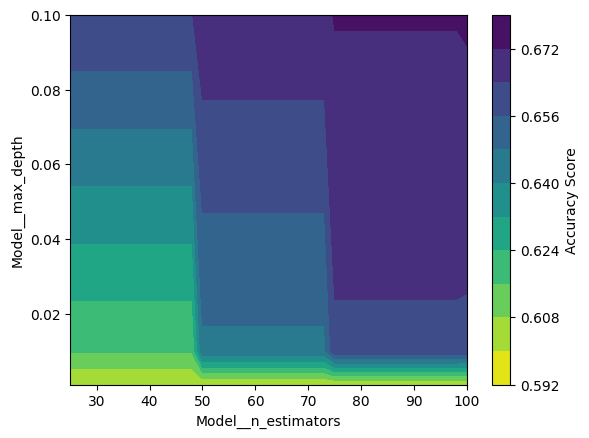

In [25]:
plot_pdp_2D_grpc(xi,yi,zi,transform_grid_plt(hyperparameters),'Model__max_depth','Model__n_estimators')

### Compute ALE Plots via gRPC

In [26]:
client = Client()
d = client.get_explanations(explanation_type='Pipeline',explanation_method='ALEPlots',param_grid=transform_grid_plt(hyperparameters),model=surrogate_model_accuracy)
json_data_list = json.loads(d)

# Create a list to store dataframes
dataframes_list_deserialized = []

# Convert each dictionary back into a dataframe
for json_data in json_data_list:
    df = pd.read_json(json_data, orient='split')
    dataframes_list_deserialized.append(df)

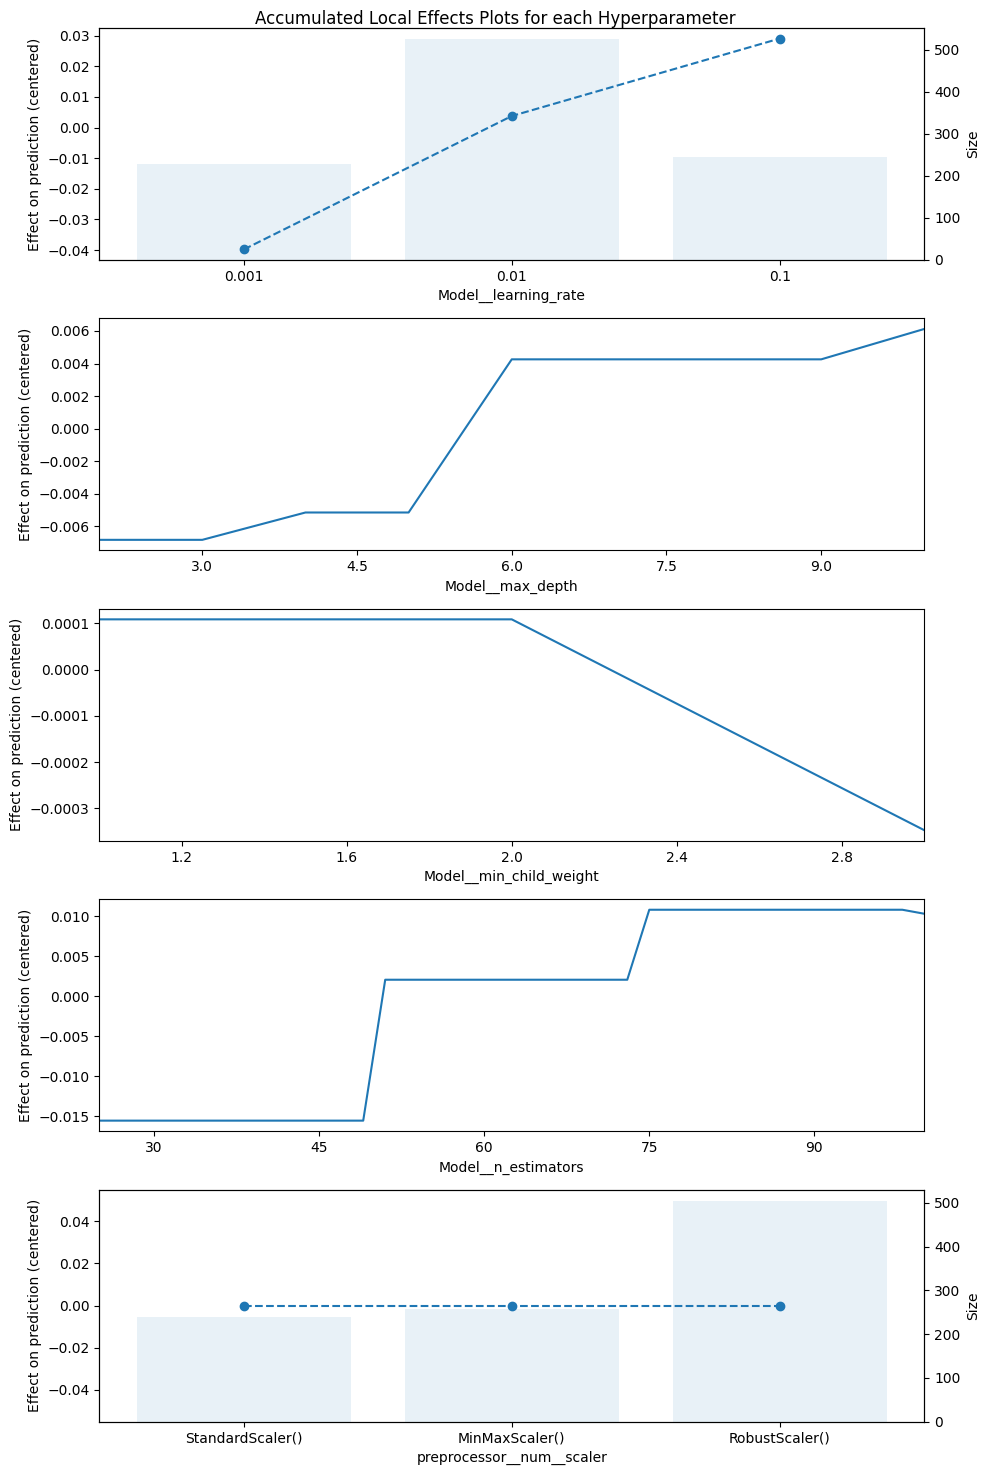

In [27]:
plot_ale_grpc(dataframes_list_deserialized,transform_grid_plt(hyperparameters))

### Compute Influence Functions via gRPC
Can be used only with torch models.

In [28]:
# # Compute influences via gRPC
# client = Client()
# inf, positive, negative = client.get_explanations(explanation_type='Pipeline',explanation_method='InfluenceFunctions',train_data=train.reset_index(drop=True),
#                                                   model = best_model, test_data = test.reset_index(drop=True).iloc[[5,10,11,14]], 
#                                                   train_labels = train_labels.reset_index(drop=True).to_frame(), test_labels = test_labels.reset_index(drop=True).loc[[5,10,11,14]],
#                                                   num_influential=5)
# # inf = pd.DataFrame(np.array(influences).reshape(6,5000),columns=[str(i) for i in range(0, 5000)])
# positive =  pd.read_parquet(io.BytesIO(positive))
# negative =  pd.read_parquet(io.BytesIO(negative))

### Counterfactual Explanations via gRPC

In [29]:
proxy_dataset.drop(columns='Unnamed: 0',inplace=True)
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T
query['preprocessor__num__scaler'] = query['preprocessor__num__scaler'].astype(str)
query['Model__learning_rate'] = query['Model__learning_rate'].astype(str)
proxy_dataset['Model__learning_rate'] = proxy_dataset['Model__learning_rate'].astype(str)

# query['Model__optimizer'] = query['Model__optimizer'].astype(str)
# query['Model__lr'] = query['Model__lr'].astype(str)

# query['Model__batch_size'] = query['Model__batch_size'].astype(np.int64)


In [30]:
client = Client()
cfs = client.get_explanations(explanation_type='Pipeline',explanation_method='CounterfactualExplanations',proxy_dataset=proxy_dataset,query=query,model=proxy_model)

In [31]:
query

,Model__learning_rate,Model__max_depth,Model__min_child_weight,Model__n_estimators,preprocessor__num__scaler
0,0.1,2,1,75,StandardScaler()


In [32]:
cfs =  pd.read_parquet(io.BytesIO(cfs))
cfs

,Model__learning_rate,Model__max_depth,Model__min_child_weight,Model__n_estimators,preprocessor__num__scaler,BinaryLabel
0,0.001,2,1,81,StandardScaler(),0
1,0.1,10,1,63,StandardScaler(),0
2,0.001,6,1,75,StandardScaler(),0
3,0.1,8,1,45,StandardScaler(),0
4,0.001,2,1,53,StandardScaler(),0


## Model Explainability

### PDPlots and 2D PDPlots via gRPC

In [33]:
client = Client()
pdp_vals, pdp_effect = client.get_explanations(explanation_type='Model',explanation_method='PDPlots',train_data=train,
                                                  model = opt.best_estimator_, features='dns_interlog_time_q1')
pdp_vals = json.loads(pdp_vals)
pdp_effect = json.loads(pdp_effect)


sending data
Stopped Sending


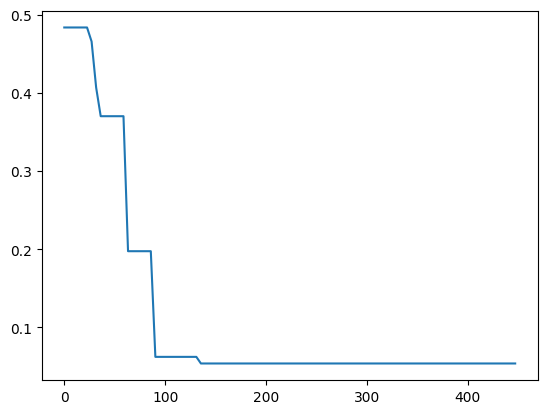

In [34]:
pdp_vals = [np.array(v) for v in pdp_vals]
pdp_effect = [np.array(v) for v in pdp_effect]
plt.plot(pdp_vals[0],pdp_effect[0])

## CounterfactualsExplanations via gRPC

In [35]:
data = pd.concat([train.reset_index(drop=True), train_labels.reset_index(drop=True)], axis = 1)

In [36]:
client = Client()
cfs = client.get_explanations(explanation_type='Model',explanation_method='CounterfactualExplanations',train_data=data,query=misclassified_instance.to_frame().T.astype(train.dtypes),model=opt.best_estimator_,target='label')

sending data
sending cf
Stopped Sending


In [37]:
misclassified_instance.to_frame().T.astype(train.dtypes)

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_is_normal,smtp_in_is_spam,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl
5,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
cfs =  pd.read_parquet(io.BytesIO(cfs))
cfs

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_is_spam,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,label
0,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,298.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,97.0,1.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,303.1,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### ALE plots via gRPC

In [39]:
client = Client()
ale_data = client.get_explanations(explanation_type='Model',explanation_method='ALEPlots',train_data=train,
                                                  model = opt.best_estimator_, features='dns_interlog_time_q1')

sending data
Stopped Sending


In [40]:
json_data_list = json.loads(ale_data)

# Create a list to store dataframes
dataframes_list_deserialized = []

# Convert each dictionary back into a dataframe
for json_data in json_data_list:
    df = pd.read_json(json_data, orient='split')
    dataframes_list_deserialized.append(df)

In [41]:
dataframes_list_deserialized[0].index.name = 'dns_interlog_time_q1'

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': '1D ALE Plot - Continuous'}, xlabel='dns_interlog_time_q1', ylabel='Effect on prediction (centered)'>)

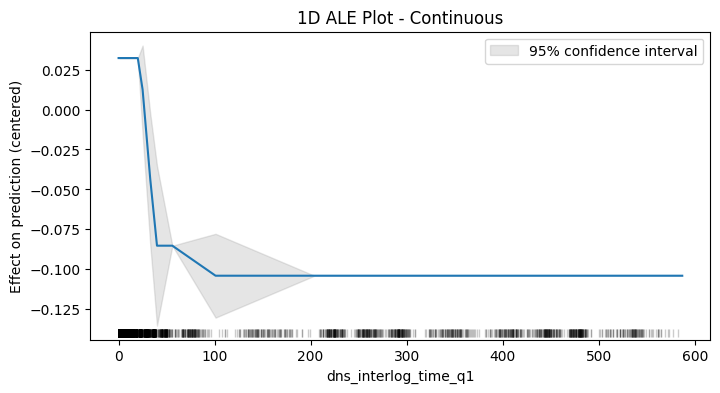

In [42]:
from PyALE._src.ALE_1D import plot_1D_continuous_eff
plot_1D_continuous_eff(dataframes_list_deserialized[0],train)